In [1]:
# fundamental libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# dataset preparation
# 1. data cleansing
import os
# 2. data loading
import cv2
from sklearn.model_selection import train_test_split
# 3. data exploration
from collections import Counter

# data preprocessing 
# 1. re-weighting
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
# 2. data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 3. x and y transformation
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image

# task 1: image classification
# traditional cnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten
# cnn with base model and fine tuning 
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from keras.regularizers import l2
# model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# task 2: image recommendation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D

## Data Preparation

### Data Cleansing

a. Exact and Rotated Image Duplicates Cleansing

In [2]:
# pip  install difPy
# NOTE: if you want to cleanse the data yourself, you can run this code! It will take a half an hour to complete.
# Else you can use the cleanedFlowers folder that already been cleansed.
# Duplicate images are removed from the dataset folder and moved to the Duplicates folder.

# from difPy import dif
# import os
# directory = "Flowers"

# if not (os.path.exists("Duplicates")):
    # os.makedirs("Duplicates")
# search = dif(directory, similarity = "duplicates" , move_to = "Duplicates")

### Data Loading

In [3]:
batch_size = 64
img_height = 160
img_width = 160

data_dir = 'manualFlowers'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4049 files belonging to 8 classes.
Using 3240 files for training.
Found 4049 files belonging to 8 classes.
Using 809 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['Babi', 'Calimero', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


### Data Exploration

2023-05-21 22:12:48.097139: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


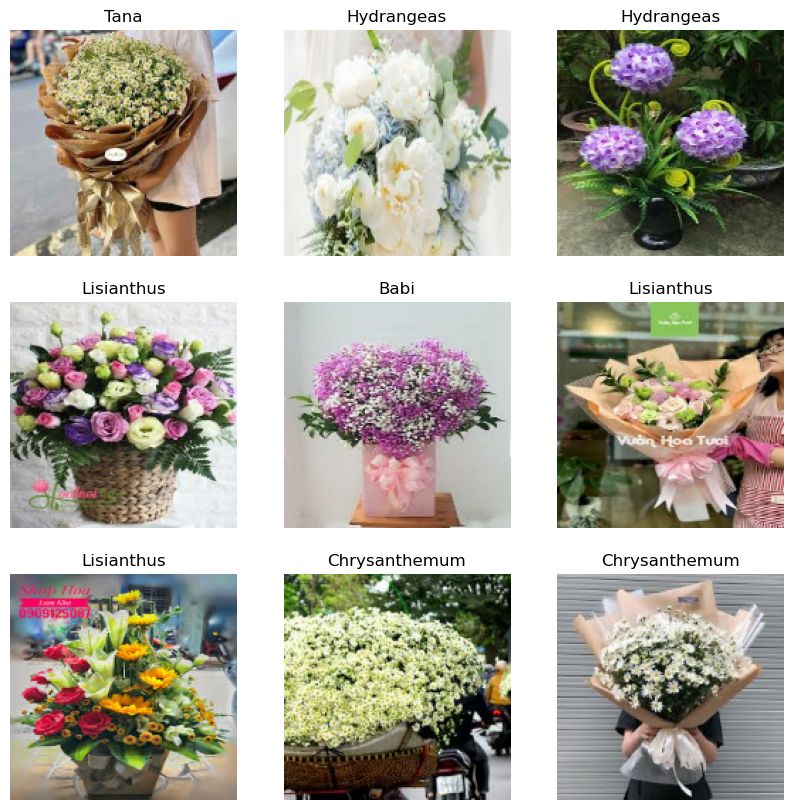

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Preprocessing

### b. Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

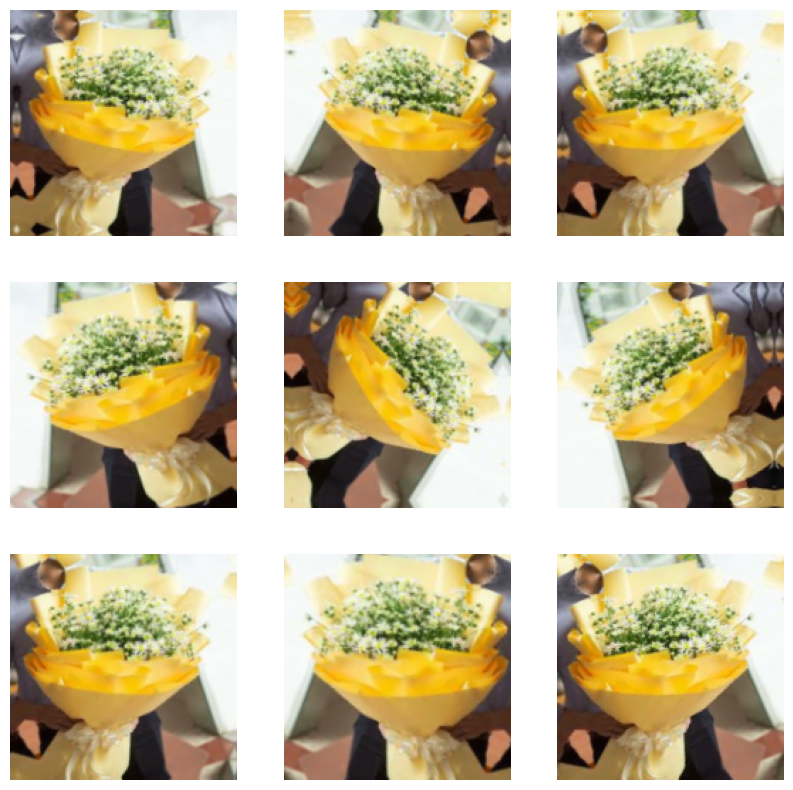

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Building Process

### IMAGE Classification

### model 1: convolutional neural network

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
epochs = 10

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(8, name="outputs")
])


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs = 7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
51/51 [==============================] - 17s 320ms/step - loss: 2.0118 - accuracy: 0.2460 - val_loss: 2.0462 - val_accuracy: 0.2311
Epoch 2/7
51/51 [==============================] - 17s 329ms/step - loss: 1.7632 - accuracy: 0.3552 - val_loss: 1.8324 - val_accuracy: 0.3523
Epoch 3/7
51/51 [==============================] - 16s 321ms/step - loss: 1.6424 - accuracy: 0.4173 - val_loss: 1.7181 - val_accuracy: 0.4067
Epoch 4/7
51/51 [==============================] - 17s 330ms/step - loss: 1.5235 - accuracy: 0.4664 - val_loss: 1.5256 - val_accuracy: 0.4697
Epoch 5/7
51/51 [==============================] - 17s 337ms/step - loss: 1.4460 - accuracy: 0.4867 - val_loss: 1.4925 - val_accuracy: 0.4660
Epoch 6/7
51/51 [==============================] - 18s 344ms/step - loss: 1.3689 - accuracy: 0.5173 - val_loss: 1.6198 - val_accuracy: 0.4475
Epoch 7/7
51/51 [==============================] - 18s 358ms/step - loss: 1.3079 - accuracy: 0.5315 - val_loss: 1.5978 - val_accuracy: 0.4524


### model 2: resnet50 based neural network

In [14]:
batch_size = 64
img_height = 160
img_width = 160

data_dir = 'manualFlowers'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4049 files belonging to 8 classes.
Using 3240 files for training.
Found 4049 files belonging to 8 classes.
Using 809 files for validation.


['Babi', 'Calimero', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


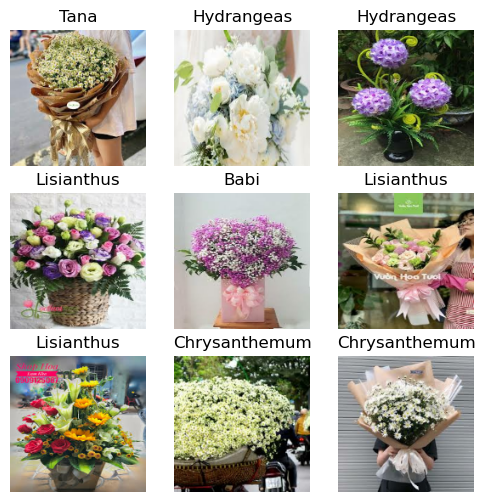

In [15]:
class_names = train_ds.class_names

print(class_names)

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

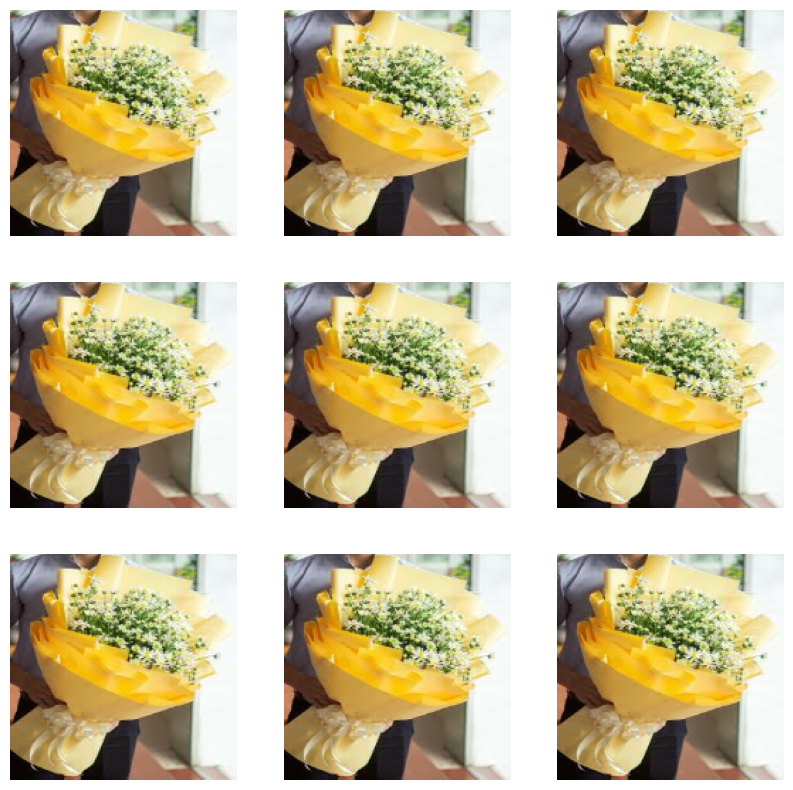

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
    
import warnings
warnings.filterwarnings("ignore", category=Warning, message=".*RngReadAndSkip.*")

In [20]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [22]:
resnet50 = tf.keras.applications.ResNet50(
    include_top = False,
    input_shape = (160, 160, 3))

resnet50.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet50.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = resnet50(image_batch)
print(feature_batch.shape)

(64, 5, 5, 2048)


In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [26]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 8)


In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet50(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 18s 1s/step - loss: 2.8468 - accuracy: 0.1273


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.85
initial accuracy: 0.13


In [31]:
num_epochs = 2

history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=validation_dataset)                   

Epoch 1/2
51/51 [==============================] - 153s 3s/step - loss: 1.2737 - accuracy: 0.5627 - val_loss: 0.9133 - val_accuracy: 0.6934
Epoch 2/2
51/51 [==============================] - 168s 3s/step - loss: 0.7600 - accuracy: 0.7340 - val_loss: 0.6825 - val_accuracy: 0.7590


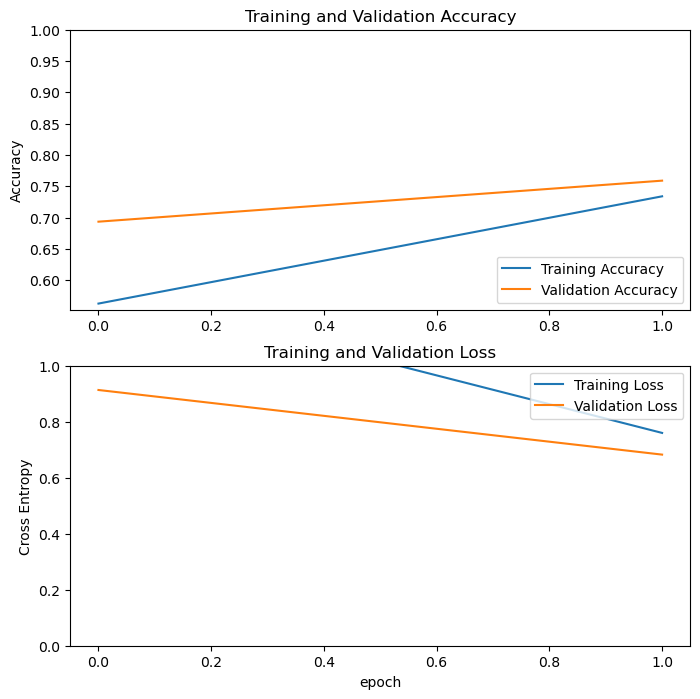

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### model 3: densenet121 based neural network

In [33]:
batch_size = 64
img_height = 160
img_width = 160

data_dir = 'manualFlowers'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4049 files belonging to 8 classes.
Using 3240 files for training.
Found 4049 files belonging to 8 classes.
Using 809 files for validation.


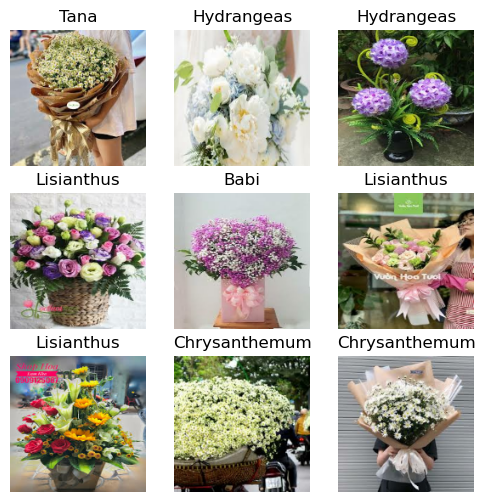

In [34]:
class_names = train_ds.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [37]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

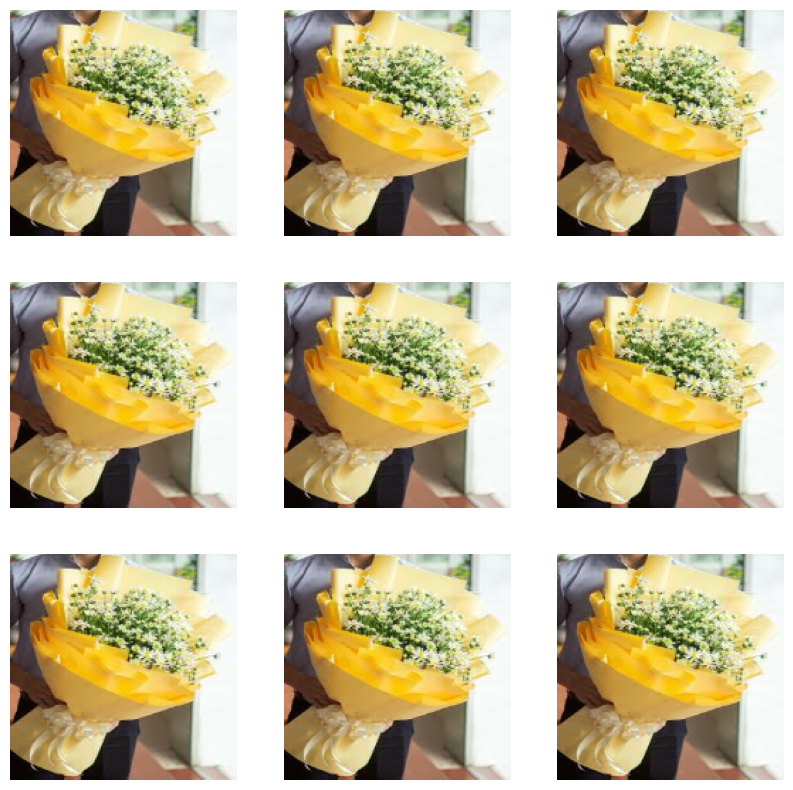

In [38]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [39]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [40]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [41]:
densenet = tf.keras.applications.DenseNet121(
    include_top = False,
    input_shape = (160, 160, 3))

densenet.trainable = True

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(densenet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  427


In [43]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = densenet(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1024)


In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1024)


In [45]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 8)


In [46]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = densenet(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [47]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 15s 1s/step - loss: 3.0448 - accuracy: 0.1199


In [49]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.04
initial accuracy: 0.12


In [50]:
num_epochs = 2

history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=validation_dataset)

Epoch 1/2
51/51 [==============================] - 159s 3s/step - loss: 1.5133 - accuracy: 0.4617 - val_loss: 1.0405 - val_accuracy: 0.6304
Epoch 2/2
51/51 [==============================] - 161s 3s/step - loss: 0.8910 - accuracy: 0.6815 - val_loss: 0.7715 - val_accuracy: 0.7441


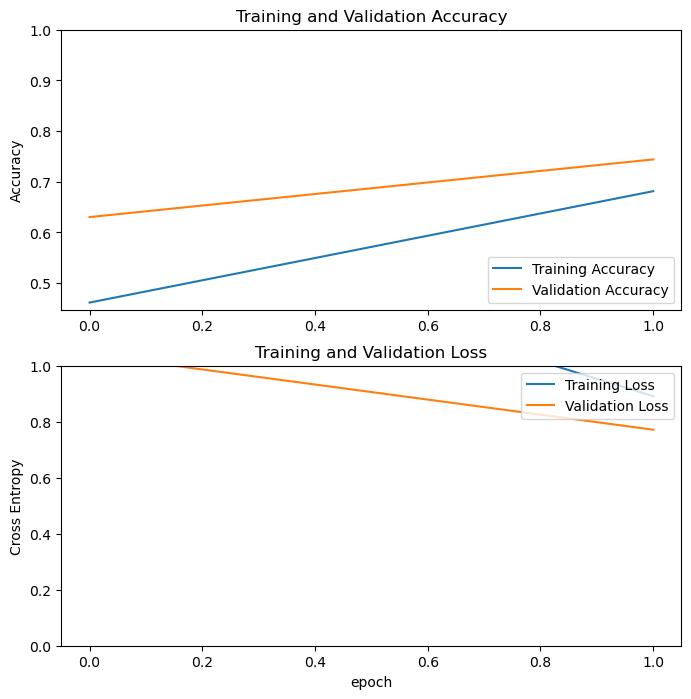

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### model 4: xception based neural network

In [52]:
batch_size = 64
img_height = 160
img_width = 160

data_dir = 'manualFlowers'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4049 files belonging to 8 classes.
Using 3240 files for training.
Found 4049 files belonging to 8 classes.
Using 809 files for validation.


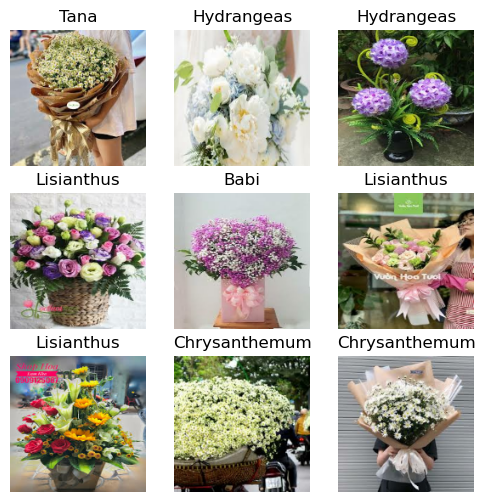

In [53]:
class_names = train_ds.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [54]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [56]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

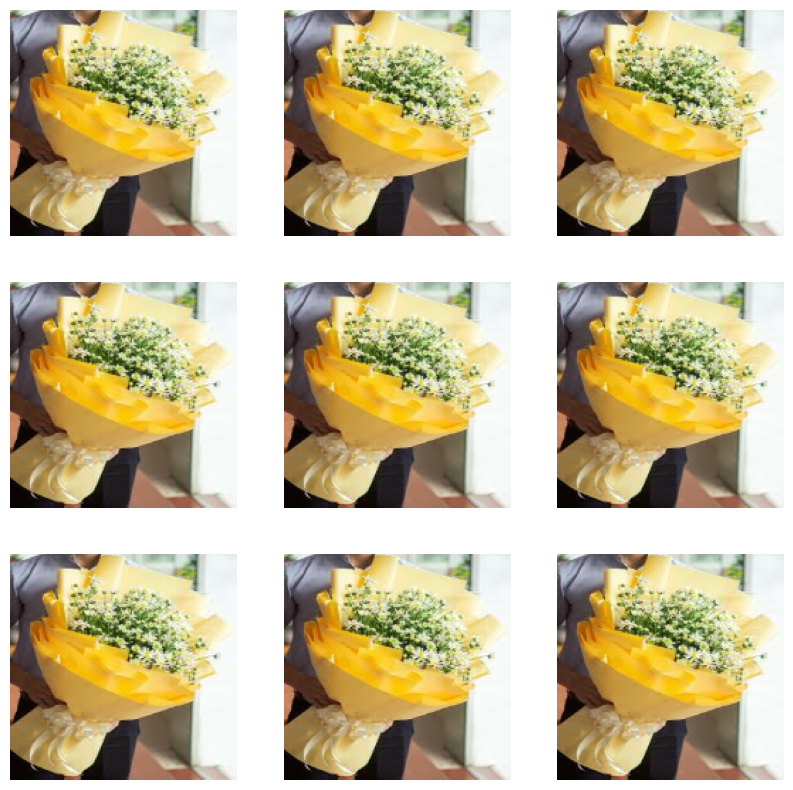

In [57]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [58]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [59]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [60]:
xception = tf.keras.applications.Xception(
    include_top = False,
    input_shape = (160, 160, 3))

xception.trainable = True

In [61]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(xception.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in xception.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [62]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = xception(image_batch)
print(feature_batch.shape)

(64, 5, 5, 2048)


In [63]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [64]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 8)


In [65]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = xception(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [66]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 19s 1s/step - loss: 2.2830 - accuracy: 0.1001


In [68]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.28
initial accuracy: 0.10


In [69]:
num_epochs = 2

history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=validation_dataset)

Epoch 1/2
51/51 [==============================] - 161s 3s/step - loss: 1.4125 - accuracy: 0.4938 - val_loss: 1.0373 - val_accuracy: 0.6465
Epoch 2/2
51/51 [==============================] - 160s 3s/step - loss: 0.9159 - accuracy: 0.6870 - val_loss: 0.8373 - val_accuracy: 0.7305


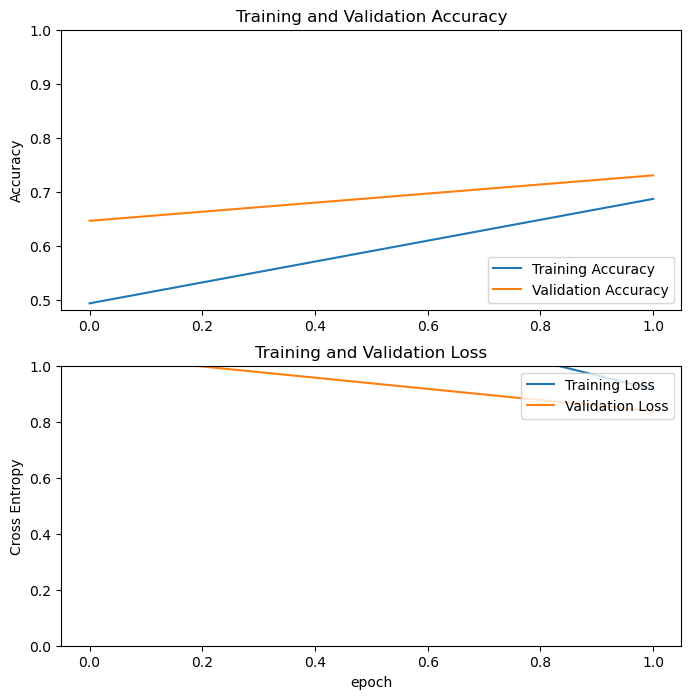

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### IMAGE Recommendation

### model 1: similarity-based recommender

In [63]:
# Set the path to the Flower dataset directory
dataset_dir = 'manualFlowers'

input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output_tensor = x

model = Model(inputs=input_tensor, outputs=output_tensor)

In [52]:
# Retrieve the list of flower directories in the dataset
flower_directories = os.listdir(dataset_dir)

# Calculate the feature vectors for the dataset images
dataset_features = []
file_paths = []  # Store file paths of dataset images
for flower_dir in flower_directories:
    flower_path = os.path.join(dataset_dir, flower_dir)
    if flower_dir == '.DS_Store':
        continue
    flower_images = os.listdir(flower_path)
    for image_name in flower_images:
        image_path = os.path.join(flower_path, image_name)
        flower_image = cv2.imread(image_path)
        flower_image = cv2.resize(flower_image, (224, 224))  # Resize to match the input size of ResNet50
        flower_image = flower_image.astype('float32')
        flower_image = preprocess_input(flower_image)
        features = model.predict(np.expand_dims(flower_image, axis=0))
        dataset_features.append(features)
        file_paths.append(image_path)

dataset_features = np.array(dataset_features)

# Flatten the dataset features
dataset_features = dataset_features.reshape(dataset_features.shape[0], -1)

1/1 [==============================] - 0s 14ms/step


/Users/andtr/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


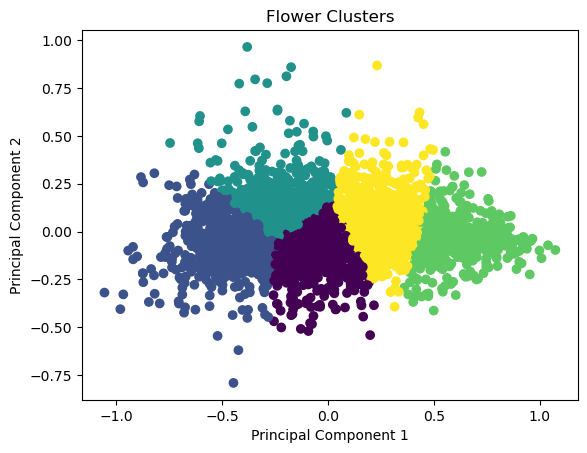

In [61]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)
dataset_features_pca = pca.fit_transform(dataset_features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(dataset_features_pca)

# Plot the clusters
plt.scatter(dataset_features_pca[:, 0], dataset_features_pca[:, 1], c=cluster_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Flower Clusters')
plt.show()

def plot_input_image(input_image_path):
    # Load the input image
    input_image = cv2.imread(input_image_path)
    # Convert BGR image to RGB for plotting
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Plot the input image
    plt.imshow(input_image)
    plt.axis('off')
    plt.show()

# Load and preprocess the input image from the user
input_image_path = 'manualFlowers/Pingpong/pingpong_10.jpg'

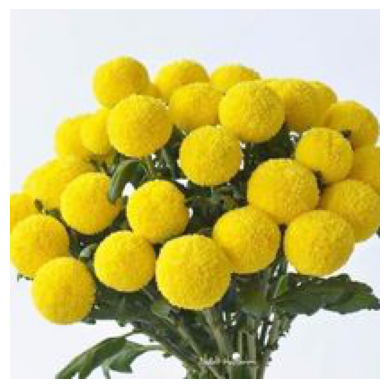

1/1 [==============================] - 0s 22ms/step


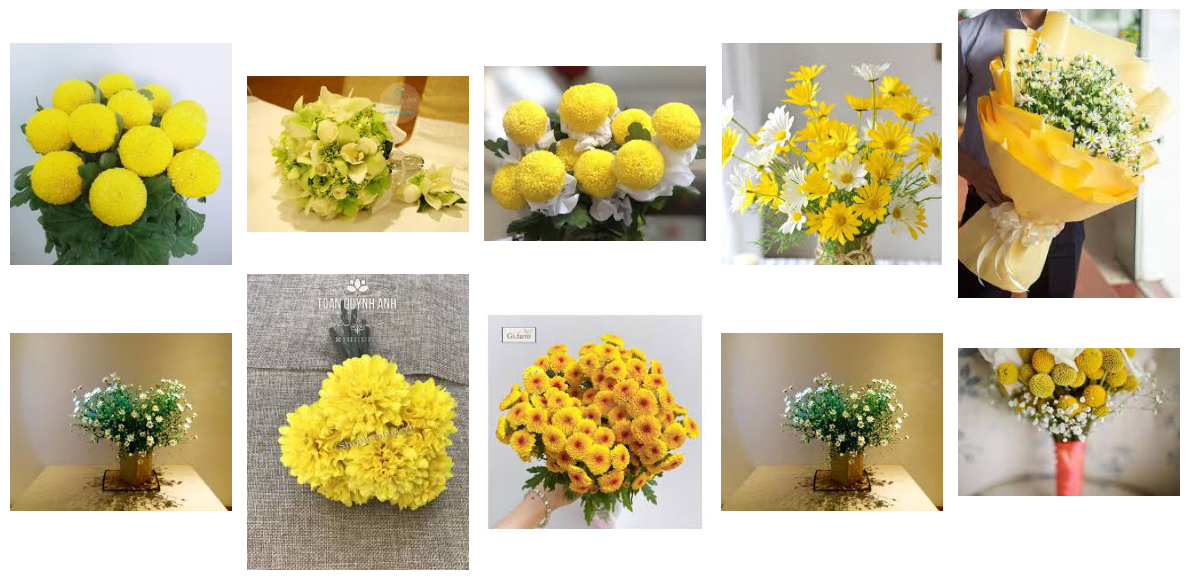

In [62]:
plot_input_image(input_image_path)

# Load the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.resize(input_image, (224, 224))  # Resize to match the input size of ResNet50
input_image = input_image.astype('float32')
input_image = preprocess_input(input_image)

# Preprocess the input image
input_image = np.expand_dims(input_image, axis=0)

# Extract features from the input image using the defined ResNet50 model
input_features = model.predict(input_image)

# Flatten the input features
input_features = input_features.reshape(input_features.shape[0], -1)

# Calculate the similarity scores between the input image and the dataset images
similarities = cosine_similarity(input_features, dataset_features)

# Sort the similarity scores in descending order and retrieve the indices of the top 10 most similar images
top_indices = np.argsort(similarities.flatten())[::-1][1:11]

# Retrieve the file paths of the top 10 images
top_file_paths = [file_paths[idx] for idx in top_indices]

def plot_images(file_paths):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    for i, file_path in enumerate(file_paths):
        img = mpimg.imread(file_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot the top 10 most similar images
plot_images(top_file_paths)